# Binary phase evaluation

We model a binary system embedded in an accretion disk, along with a dark matter spike and gravitational waves emission.
The goal for our modelization is to produce an estimate of the following quantity: 

\begin{equation}
    \dot{r} = \dot{r}_{\mathrm{gas}} + \dot{r}_{\mathrm{DF}} + \dot{r}_{\mathrm{GW}}\text{,}
\end{equation}

where $\dot{r}_\mathrm{gas}$ is the contribution coming from gas torques from the accretion disk surrounding the binary, $\dot{r}_\mathrm{DF}$ is the effect of dynamical friction from the presence of the dark matter spike, and $\dot{r}_\mathrm{GW}$ is the contribution from the gravitational waves emission. Specifically, we adopt the classical Newtonian formalism, computing the results from the reduced mass-system, and in case assuming that $m_1 \gg m_2$.

Once the shape of $\dot{r}$ is clear, one can evaluate the phase of the binary system from a generic $f$-frequency to the $f_{\mathrm{isco}}$-frequency. Assuming circular orbits the frequency is:

\begin{equation}
    f = \frac{1}{\pi} \sqrt{\frac{G(m_1 + m_2)}{r^3}}\text{.}
\end{equation}

We can evaluate $\Phi(f)$ as: 

\begin{equation}
    \Phi(f) = \int_{f}^{f_{\mathrm{isco}}} \frac{dt}{df'} f' df'\text{,}
\end{equation}

where the relation $\frac{dt}{df'}$ is extracted directly from the expression in the above equation by the following chain rule: $\frac{dr}{dt} \frac{df}{dr} = \frac{df}{dt}$. 

## Expressions for the $\dot{r}_i$ contributions

- Accretion disk's torques: 

\begin{equation}
    \dot{r}_\mathrm{gas} = - 2 \Sigma_0 \frac{r^{\gamma + 3/2}}{r_0^\gamma} \frac{G^{1/2} (m_1 + m_2)^{1/2}}{\mu} q^{2} \mathcal{M}^2\text{.}
\end{equation}

- Dark matter spike's dynamical friction:

Static:

\begin{equation}
\label{eq:r_dot_DF}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}}\text{,}
\end{equation}

Time dependent:

\begin{equation}
\label{eq:r_dot_DF_time}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}} \cdot r^{-5/2}\text{.}
\end{equation}

- Gravitational waves: 

\begin{equation}
\label{eq:r_dot_gw}
    \dot{r}_{\mathrm{GW}} = - \frac{64 (m_1 + m_2) G^3 m_1 m_2}{5 c^5 r^3}\text{.}
\end{equation}

In the code, there will be enabled the possibility to choose which of these options to keep in the final formula, which will account for the sum of all the contributions the user requires. 

## Formulas to use and implement "in code" for the phase evaluation

I used the following quantities: 

- Derivative of f in radial separation:

\begin{equation}
\label{eq:dfdr}
    \frac{df}{dr} = \frac{1}{\pi} (-\frac{3}{2}) \sqrt{\frac{G (m_1 + m_2)}{r^5}}\text{.}\\
\end{equation}


- Inverse of f(r):

\begin{equation}
\label{eq:r(f)}
    r(f) = \sqrt[3]{\frac{G (m_1 + m_2)}{\pi^2 f^2}}\text{,}\\
\end{equation}

- Derivative of f in time:

\begin{equation}
\label{eq:dfdt}
    \frac{df}{dt} = \dot{r} \frac{df}{dr}\text{,}\\
\end{equation}

- Second derivative of the phase in time:

\begin{equation}
\label{eq:phi_dot-dot}
    \ddot{\Phi}(f) = 4 \pi^2 f \left(\frac{d\Phi(f)}{df}\right)^{-1} 
\end{equation}

# Code implementation

### Libraries and constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy as sp
from scipy.integrate import quad, simps 
from scipy.special import hyp2f1, betainc
import pandas as pd

In [2]:
# Define some constants: 

G = 6.67408e-11 # kg^-1 m^3 / s^2
c = 299792458.0 # m / s
pc = 3.08567758149137e16 # m
m_sun = 1.98855e30 # kg

In [3]:
# Fix parameters:

m1 = 1.4 * 1e3 * m_sun 
m2 = 1.4 * m_sun 
q = m2/m1
M_tot = m1 + m2
mu = m1 * m2 / M_tot
chirp_mass = (m1 * m2)**(3/5) / (M_tot)**(1/5)

### Dark matter spike environment

For the moment we are going to concentrate on the dark matter spike environment only.

In [4]:
# Spike: data taken from paper (https://arxiv.org/abs/2002.12811)

gammas = 7/3
rho_sp =  226 * m_sun / (pc)**3
r_sp = ((3 - gammas) * 0.2 ** (3 - gammas) * m1 / (2 * np.pi * rho_sp)) ** (1 / 3)
epsv = 0.58 
logL = 1 / q**(1/2)

r_isco = 6 * m1 * G / c**2 # of central bh

### Various functions: 

Down below I report the implementation of the functions we need. 

In [5]:
def rho_dm(r):
    
    '''Finds the density profile of the dark matter using the above formulation.'''
    
    return rho_sp * (r_sp / r)**(gammas)

In [6]:
def frequency(r):
        
    '''Finds the binary frequency assuming circular orbits, at fixed radius r.'''
        
    return 1 / (np.pi) * np.sqrt(G * m1 / r**3)

In [7]:
def binary_separation(f):
        
    '''Finds the binary frequency assuming circular orbits, at fixed radius r.'''
        
    return (G * m1 / (f**2 * np.pi**2))**(1/3)

In [8]:
def df_dr(r): 
    
    '''Finds the binary frequency radial derivative assuming circular orbits.'''
        
    return 1 / np.pi * (- 3 / 2) * np.sqrt(G * m1 / r**5)

In [9]:
def df_dt(r, dot_r): # I left the expression of dot_r since I already evaluated it above, can be corrected to be a single function doing it all on its own 
    
    '''Finds the binary frequency time derivative.'''
    
    return df_dr(r) * dot_r

In [10]:
def yes_or_no(elem):
    
    '''Checks whether you want a contribution or not. (could be made boolean directly)'''
        
    if elem=='y': 
        
        return 1
    
    return 0

In [11]:
def dot_r(r):
    
    '''Find the binary change in separation over time, asking the user to choose which contribution to keep.'''
        
    acc = ''
    dm = ''
    gw = ''
    
    while(dm != 'y' and dm != 'n'):
        print('Include the dark matter contribution? (y/n)')
        dm = input()
    
    while(gw != 'y' and gw != 'n'):
        print('Include the GW contribution? (y/n)')
        gw = input()
    
    r_dot_dm = - 8 * np.pi * G**(1/2) * m2 * logL * rho_dm(r) * epsv * r**(5/2) / (m1 * M_tot**(1/2)) 
    
    r_dot_gw = - 64 * M_tot * G**3 * m1 * m2 / (5 * c**5 * r**3)
    
    
    return yes_or_no(dm) * r_dot_dm + yes_or_no(gw) * r_dot_gw

In [12]:
def phase_f_by_hand(df_dt): 
    
    '''Finds the binary phase as a function of frequency.'''
    
    freqs = frequency(r_grid)
    to_integrate = 2 * np.pi * df_dt**(-1) * freqs
    phase_f = []
    
    for b in freqs:  # range of values for the lower limit
        
        # Select the appropriate range of f values for integration
        f_range = freqs[freqs >= b]
        
        phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))

    return np.array(phase_f)

In [13]:
def ddot_phase_f(df_dt): 
    
    '''Finds the binary second derivative phase as a function of frequency, using the equations above.'''
    
    return 2 * np.pi * df_dt

In [14]:
def h_0(f, ddot_phase):
    
    '''Finds the strain as a function of frequency, and \ddot{\Phi}'''
    
    return 1/2 * 4 * np.pi**(2/3) * G**(5/3) * chirp_mass**(5/3) * f**(2/3) / c**4 * (2 * np.pi / ddot_phase)**(1/2) / (4 * 10**9 * pc)

Define the domain of frequencies axis. 

In [16]:
# Set a grid of radial distances

f_LISA = 1e-3 # Hz
r_max = binary_separation(f_LISA)

r_grid = np.linspace(r_isco, r_max, 10000)

## From the Git-library

https://github.com/pipcole/pydd/blob/main/src/pydd/binary.py#L45 

I here copy the functions used to estimate the phase to coalescence used in the paper. 

In [17]:
def hypgeom_scipy(b, z):
    
    return hyp2f1(1, b, 1 + b, z)

#---------------------------------------------

def _Phi_to_c_indef_s(f):
    
    c_f = 5 * c**5 / (8 * m1**2) * np.pi**(2 * (gammas - 4) / 3) * G**(- (2 + gammas)/3) * M_tot**((1 - gammas) / 3) *\
    r_sp**(gammas) * epsv * rho_sp * logL
    
    f_eq =  c_f ** (3 / (11 - 2 * gammas))
    
    a_v = 1 / 16 * (c ** 3 / (np.pi * G * chirp_mass)) ** (5 / 3)
    
    x = f / f_eq
    th = 5 / (11 - 2 * gammas)
    
    return a_v / f ** (5 / 3) * hypgeom_scipy(th, -(x ** (-5 / (3 * th))))

#---------------------------------------------

def phasePN(nu, v):
    return (3715/1008 + 55 * nu /12) * v**2 - 10 * np.pi * v**3 +(15293365/1016064 + 27145 * nu /1008 + 3085 * nu**2 / 144) * v**4

#---------------------------------------------

def _Phi_to_c_indef_v(f):
    
    nu1 = m1 * m2/(m1 + m2)**2
    v1 = ((G/c**3) * np.pi * (m1 + m2) * f)**(1/3)
    a_v = 1 / 16 * (c ** 3 / (np.pi * G * chirp_mass)) ** (5 / 3)
    PN = 0
    
    return a_v / f ** (5 / 3) * (1 + PN * phasePN(nu1, v1)) # params.PN *

In [19]:
# Check the frequencies are ok:

freqs = frequency(r_grid)
f_isco = frequency(r_isco)

print('f_isco_GW:', f_isco)
print('f_isco_grid_GW:', freqs[0])

f_isco_GW: 3.1407213111030896
f_isco_grid_GW: 3.1407213111030896


In [20]:
phase_check_from_code = _Phi_to_c_indef_s(freqs) - _Phi_to_c_indef_s(f_isco)
phase_check_from_code_v = _Phi_to_c_indef_v(freqs) - _Phi_to_c_indef_v(f_isco)

---

### From the paper on effective DM

In [21]:
def phase_effective_dm(phase_vacuum):
    
    freqs = frequency(r_grid)
    
    gamma_e = 5/2 #?
    
    theta = 5 / (2 * gamma_e)
    
    c_f = 5 * c**5 / (8 * m1**2) * np.pi**(2 * (gammas - 4) / 3) * G**(- (2 + gammas)/3) * M_tot**((1 - gammas) / 3) *\
    r_sp**(gammas) * epsv * rho_sp * logL
    
    f_eq = c_f**(3 / (11 - 2 * gammas))
    
    lambda_ = (11 - 2 * (gammas + gamma_e)) / 3
    
    f_b = 0.8163 * (m1 / (1000 * m_sun))**(-1.4412) * (m2 / m_sun)**(0.4511) * (1 - 0.4971 * np.log(gammas / 1.4396))
    
    eta = (5 + 2 * gamma_e) / (2 * (8 - gammas)) * (f_eq / f_b)**((11 - 2 * gammas) / 3)
    
    f_t = f_b
    
    y = freqs / f_t
    
    gauss_hypergeom = hyp2f1(1, theta, 1 + theta, - y**(-5/(3 * theta)))
    
    return phase_vacuum * (1 - eta * y**(-lambda_) * (1 - gauss_hypergeom))

In [22]:
df_dr_s = df_dr(r_grid)

- Time derivative of the radial separation: 

In [23]:
dot_r_dm = dot_r(r_grid)

Include the dark matter contribution? (y/n)
y
Include the GW contribution? (y/n)
y


In [24]:
dot_r_gw = dot_r(r_grid)

Include the dark matter contribution? (y/n)
n
Include the GW contribution? (y/n)
y


- Phase: adopt two methods and compare their outcome.

In [25]:
df_dt_dm = df_dt(r_grid, dot_r_dm)
df_dt_gw = df_dt(r_grid, dot_r_gw)

phi_dm_bh = phase_f_by_hand(df_dt_dm)
phi_gw_bh = phase_f_by_hand(df_dt_gw)

phi_dm_effective = phase_effective_dm(phi_gw_bh) 

In [30]:
# Open pickle file from Pippa, check consistency

freqs_check = np.linspace(1e-2, f_isco, 500)
phase = pd.read_pickle(r'static_phase_to_c.pickle')

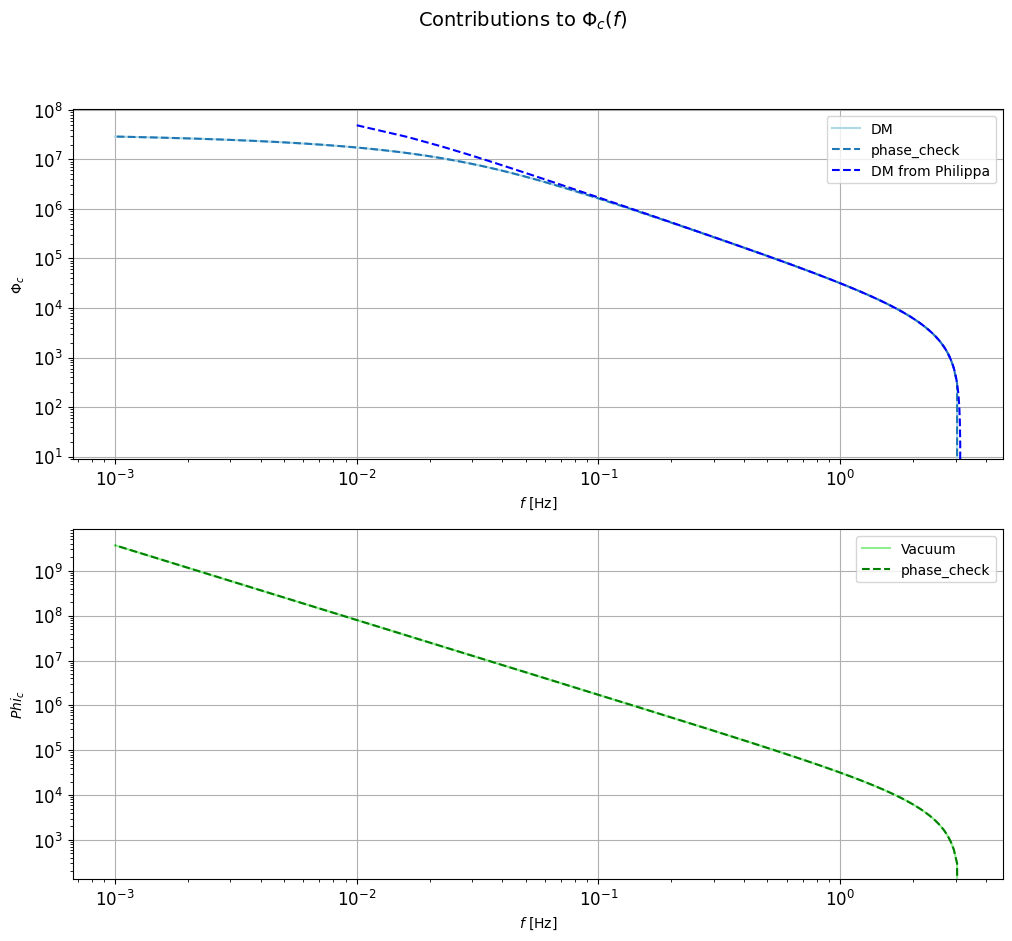

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

plt.suptitle('Contributions to $\Phi_c(f)$', fontsize=14)


axs[0].loglog(freqs, -phi_dm_bh, c='lightblue', linestyle='-', label='DM')
axs[0].loglog(freqs, phase_check_from_code, label='phase_check', linestyle='--');
axs[0].loglog(freqs_check, phase, c='blue', linestyle='--', label='DM from Philippa')
axs[0].set_xlabel('$f$ [Hz]', fontsize=10)  
axs[0].set_ylabel(r'$\Phi_c$', fontsize=10) 
axs[0].tick_params(axis='x', labelsize=12)  
axs[0].tick_params(axis='y', labelsize=12)  
axs[0].grid(True) 
axs[0].legend()  

axs[1].loglog(freqs, -phi_gw_bh, c='lightgreen', linestyle='-', label='Vacuum')
axs[1].loglog(freqs, phase_check_from_code_v, label='phase_check', linestyle='--', c='green');
axs[1].set_xlabel('$f$ [Hz]', fontsize=10) 
axs[1].set_ylabel(r'$Phi_c$', fontsize=10) 
axs[1].tick_params(axis='x', labelsize=12) 
axs[1].tick_params(axis='y', labelsize=12) 
axs[1].grid(True) 
axs[1].legend() 

plt.savefig('results-images/phases_dm.png')
plt.show()

- Difference in phase between vacuum case and environment cases $(\Phi_{\mathrm{GW}} - \Phi_{\mathrm{env}}) / 2\pi$: 

In [32]:
# Check with paper's results (https://arxiv.org/pdf/2002.12811.pdf)

data_check_f_static = [0.009526807029019828 ,
0.023546687741918298 ,
0.054555947811685254 ,
0.10581845187471557  ,
0.32793628590208834  ,
0.636075652236592    ,
1.233752569512859    ,
2.003338724289298]

data_check_phi_static = [73359357.15345764,
 5956529.827473827,
 340266.6584782468,
 29526.438189399316,
 416.700163491837,
 33.70997904099187,
 2.7270512145272456,
 0.4436302031743549]



# effective

data_check_f = [0.006895987907029673, 
                0.03762171563659231, 
                0.1636948769202407, 
                0.49116574461187135, 
                1.2742749857031348, 
                2.9524016447543264,   
                4.212708446819448,   
0.01546940765246201]

data_check_phi = [880109.0120801813, 
                  23550.550789353365, 
                  891.7719485147651,
                  44.4504370321179,
                  2.0610077045538233,
                  0.07206223392181468,
                  0.003809526150404238,
                  165544.7104557622]

In [33]:
# Open pickle file from Pippa, and check consistency

dephase = pd.read_pickle(r'static_dephase.pickle')

In [34]:
# Define effective params 

c_f = 5 * c**5 / (8 * m1**2) * np.pi**(2 * (gammas - 4) / 3) * G**(- (2 + gammas)/3) * M_tot**((1 - gammas) / 3) * r_sp**(gammas) * epsv * rho_sp * logL
f_eq = c_f**(3 / (11 - 2 * gammas))
f_b = 0.8163 * (m1 / (1000 * m_sun))**(1.4412) * (m2 / m_sun)**(0.4511) * (1 - 0.4971 * np.log(gammas / 1.4396))

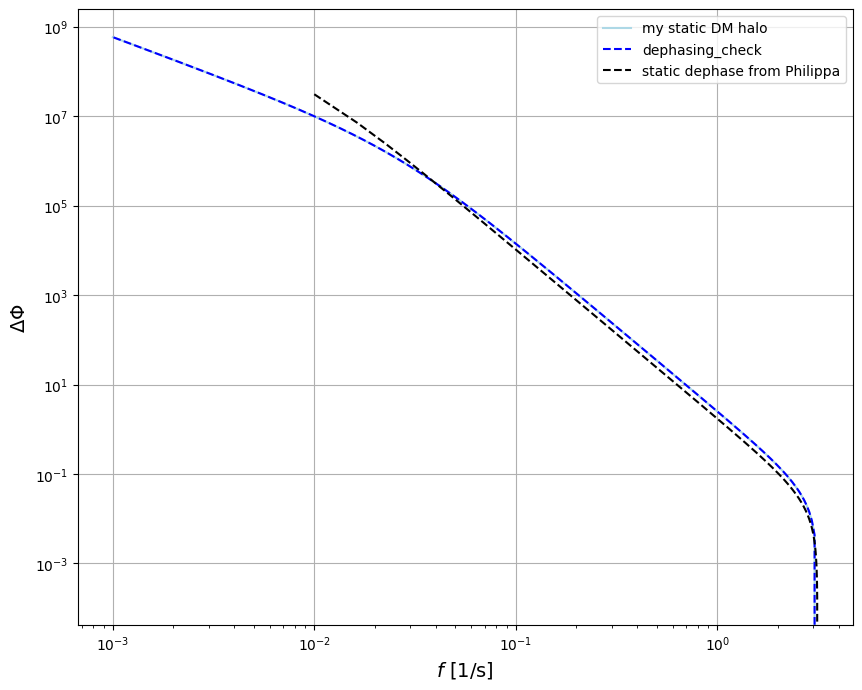

In [35]:
plt.figure(figsize=(10, 8))

plt.loglog(freqs, (+phi_dm_bh - phi_gw_bh)/(2 * np.pi), c='lightblue', label='my static DM halo', linestyle='-')
plt.loglog(freqs, (-phase_check_from_code + phase_check_from_code_v)/(2 * np.pi), c='blue', label='dephasing_check', linestyle='--')
plt.loglog(freqs_check, dephase, c='black', linestyle='--', label='static dephase from Philippa')
#plt.loglog(freqs, (phi_dm_effective - phi_gw_bh)/(2 * np.pi), c='blue', label='effective DM halo')
plt.xlabel('$f$ [1/s]', fontsize=14) 
plt.ylabel(r'$\Delta\Phi$', fontsize=14)  
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10) 
plt.grid(True)
plt.tick_params(axis='y', which='minor')
plt.legend(fontsize='medium')

plt.savefig('results-images/test_dm_static.png');

## Include effective phase into "all"-derivation

We now want to include the effective phase on a more complex level: with the whole set of possible contributions from all the environments. To do so we need to work "backwards" and extrapolate the solution for $\dot{r}_{\mathrm{DM, eff}}$ to add to all the others. 

In [36]:
def hyp2f1_derivative(hyp2f1, f):
    
    delta_function = np.concatenate(([np.min(hyp2f1)], hyp2f1[1:] - hyp2f1[:-1]))
    delta_fs = np.concatenate(([np.max(f)], f[1:] - f[:-1]))
    
    return delta_function/delta_fs

In [37]:
def vacuum_phase(freqs, f_isco):
    
    return -G**(-5/3) * (M_tot)**(1/3) * c**5 / (16 * np.pi**(5/3) * m1 * m2) * (freqs**(-5/3) - f_isco**(-5/3))

In [38]:
def dvacuum_phase_df(freqs):
    
    return -G**(-5/3) * (M_tot)**(1/3) * c**5 / (16 * np.pi**(5/3) * m1 * m2) * (-5/3) * (freqs**(-5/3-1))

In [41]:
def find_dot_r_effDM(r):
    
    # Needed quantities
    
    freqs = frequency(r)

    df_dr_s = df_dr(r)
    
    # Vacuum quantities
    
    phase_vacuum =  vacuum_phase(freqs, f_isco)
    
    dphase_vacuum_df = dvacuum_phase_df(freqs)
    
    # From paper
    
    gamma_e = 5/2 
    
    theta = 5 / (2 * gamma_e)
    
    c_f = 5 * c**5 / (8 * m1**2) * np.pi**(2 * (gammas - 4) / 3) * G**(- (2 + gammas)/3) * M_tot**((1 - gammas) / 3) *\
    r_sp**(gammas) * epsv * rho_sp * logL
    
    f_eq = c_f**(3 / (11 - 2 * gammas))
    
    lambda_ = (11 - 2 * (gammas + gamma_e)) / 3
    
    f_b = 0.8163 * (m1 / (1000 * m_sun))**(-1.4412) * (m2 / m_sun)**(0.4511) * (1 - 0.4971 * np.log(gammas / 1.4396))
    
    eta = (5 + 2 * gamma_e) / (2 * (8 - gammas)) * (f_eq / f_b)**((11 - 2 * gammas) / 3)
    
    f_t = f_b
    
    # Variables 
    
    y = freqs / f_t
    
    dy_df = 1 / f_t
    
    # Hypergeometric function
    
    gauss_hypergeom = hyp2f1(1, theta, 1 + theta, - y**(-5/(3 * theta)))
    
    dgauss_hypergeom_df = hyp2f1_derivative(gauss_hypergeom, freqs)
    
    # Find phase derivative in frequency
    
    braket = y**(-lambda_) * (1 - gauss_hypergeom)
    
    d_phase_df_s = dphase_vacuum_df - eta * (dphase_vacuum_df * braket - lambda_ / y * dy_df * braket * phase_vacuum + phase_vacuum * y**(-lambda_) * (-dgauss_hypergeom_df * dy_df))
    
    df_dt = 2 * np.pi * freqs / d_phase_df_s
    
    return df_dt * df_dr_s**(-1)

In [42]:
dot_r_eff_dm = find_dot_r_effDM(r_grid)

In [43]:
df_dt_eff_dm = df_dt(r_grid, dot_r_eff_dm)

In [44]:
phi_eff_dm = phase_f_by_hand(df_dt_eff_dm)

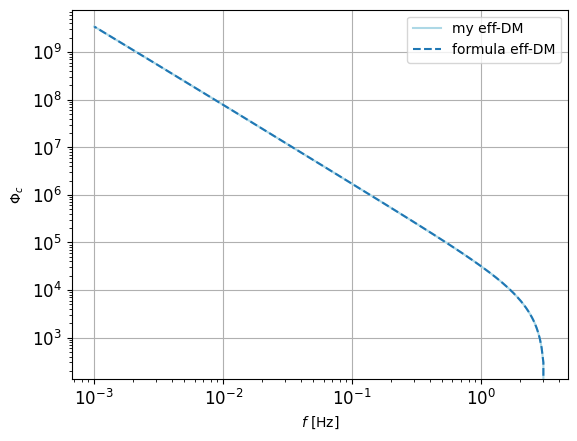

In [54]:
# Check if they overlap

plt.loglog(freqs, -phi_eff_dm, c='lightblue', linestyle='-', label='my eff-DM')
plt.loglog(freqs, -phi_dm_effective, linestyle='--', label='formula eff-DM');
plt.xlabel('$f$ [Hz]', fontsize=10)  
plt.ylabel(r'$\Phi_c$', fontsize=10) 
plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)  
plt.grid(True)
plt.legend();

In [50]:
def static_phase(f): 
    
    phase_vacuum = vacuum_phase(freqs, f_isco)
    
    theta = 5 / (11 - 2 * gammas)
    
    c_f = 5 * c**5 / (8 * m1**2) * np.pi**(2 * (gammas - 4) / 3) * G**(- (2 + gammas)/3) * M_tot**((1 - gammas) / 3) *\
    r_sp**(gammas) * epsv * rho_sp * logL
    
    gauss_hypergeom = hyp2f1(1, theta, 1 + theta, - c_f * f**(-(11 - 2 * gammas) / 3))
    
    return phase_vacuum * gauss_hypergeom

In [51]:
phase_static_dm = static_phase(freqs)

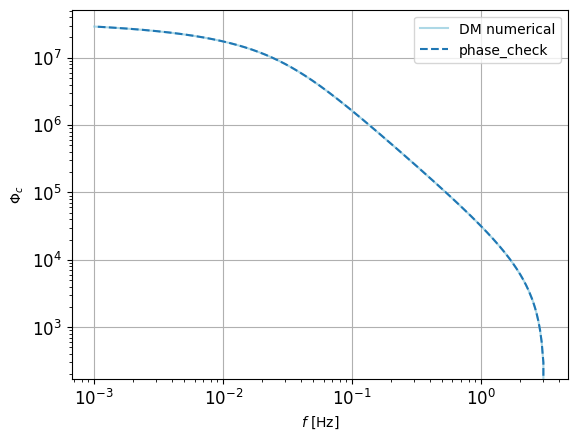

In [53]:
plt.loglog(freqs, -phi_dm_bh, c='lightblue', linestyle='-', label='DM numerical')
plt.loglog(freqs, -phase_static_dm, label='phase_check', linestyle='--');
plt.xlabel('$f$ [Hz]', fontsize=10)      
plt.ylabel(r'$\Phi_c$', fontsize=10)     
plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)  
plt.grid(True)
plt.legend();

## QUESTION:

Is any contribution to $\dot{r}_{tot}$ linear? To be clear: if we have dm effective we do not include $\dot{r}_{GW}$. 

### IF SO:

We now consider the whole combination of environments: we need to add the accretion disk.

In [55]:
# Accretion params

r_s = 2 * G * m1 / c**2 # Schwartzschild radius of m1
r0 = 3 * r_s
Mach = 100 
sigma0 = 1.5 * 10**10 / Mach**2
gamma = -1/2

In [56]:
def sigma_acc(r): 
    
    return sigma0 * (r / r0)**(gamma)

def gas_torque(r): 
    
    return - sigma_acc(r) * r**4 * (G * M_tot / r**3) * q**2 * Mach**2

In [59]:
# Change dot_r into:

def dot_r_complete(r):
    
    '''Find the binary change in separation over time, asking the user to choose which contribution to keep.'''
        
    dm_eff = ''
    dm = ''
    gw = ''
    acc = ''
    
    while(dm != 'y' and dm != 'n'):
        print('Include the static dark matter contribution? (y/n)')
        dm = input()
        
    if(dm == 'n'): 
        
        while(dm_eff != 'y' and dm_eff != 'n'):
            print('Include the effective dark matter contribution? (y/n)')
            dm_eff = input()
            
        if(dm_eff == 'y'): 
            
            gw = 'n'
    
    while(gw != 'y' and gw != 'n'):
        print('Include the GW contribution? (y/n)')
        gw = input()
        
    while(acc != 'y' and acc != 'n'):
        print('Include the accretion disk contribution? (y/n)')
        acc = input()
        
    print('-----')
    
    r_dot_dm = - 8 * np.pi * G**(1/2) * m2 * logL * rho_dm(r) * epsv * r**(5/2) / (m1 * M_tot**(1/2)) 
    
    r_dot_gw = - 64 * M_tot * G**3 * m1 * m2 / (5 * c**5 * r**3)
    
    r_dot_dm_eff = find_dot_r_effDM(r)
    
    r_dot_acc = 0.5 * gas_torque(r) * m2**(-1) * r**(1/2) * (G * M_tot)**(-1/2)
    
    return yes_or_no(dm) * r_dot_dm + yes_or_no(gw) * r_dot_gw + yes_or_no(dm_eff) * r_dot_dm_eff + yes_or_no(acc) * r_dot_acc

In [60]:
r_dot_TOTAL = dot_r_complete(r_grid)
r_dot_vacuum = dot_r_complete(r_grid)

Include the static dark matter contribution? (y/n)
n
Include the effective dark matter contribution? (y/n)
y
Include the accretion disk contribution? (y/n)
y
-----
Include the static dark matter contribution? (y/n)
n
Include the effective dark matter contribution? (y/n)
n
Include the GW contribution? (y/n)
y
Include the accretion disk contribution? (y/n)
n
-----


In [61]:
df_dt_TOTAL = df_dt(r_grid, r_dot_TOTAL)
df_dt_vacuum = df_dt(r_grid, r_dot_vacuum)

phi_TOTAL = phase_f_by_hand(df_dt_TOTAL)
phi_vacuum = phase_f_by_hand(df_dt_vacuum)

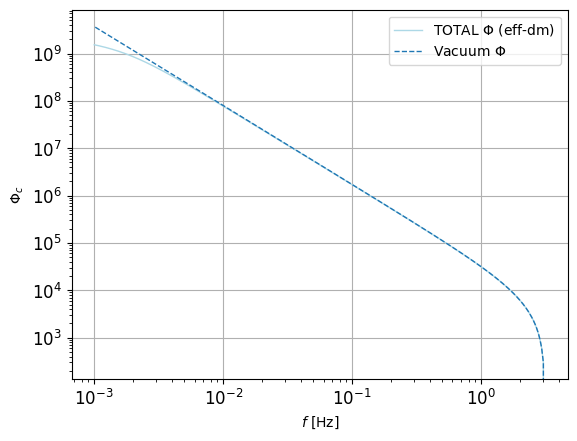

In [63]:
plt.loglog(freqs, -phi_TOTAL, c='lightblue', linestyle='-', label='TOTAL $\Phi$ (eff-dm)', linewidth=1)
plt.loglog(freqs, -phi_vacuum, linestyle='--', label='Vacuum $\Phi$', linewidth=1)
plt.xlabel('$f$ [Hz]', fontsize=10)      
plt.ylabel(r'$\Phi_c$', fontsize=10)     
plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)  
plt.grid(True)
plt.legend();

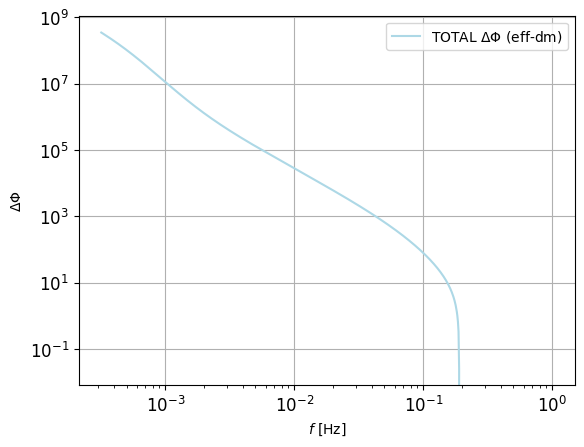

In [64]:
# Dephasing 

plt.loglog(freqs/f_isco, (phi_TOTAL - phi_vacuum)/(2 * np.pi), c='lightblue', linestyle='-', label='TOTAL $\Delta\Phi$ (eff-dm)')
plt.xlabel('$f$ [Hz]', fontsize=10)      
plt.ylabel(r'$\Delta\Phi$', fontsize=10)     
plt.tick_params(axis='x', labelsize=12)  
plt.tick_params(axis='y', labelsize=12)  
plt.grid(True)
plt.legend();